## Demonstration of Chess Manipulation Station under Teleop

This is a quick demonstration of the chess manipulation station using teleop.
It allows for debugging of kinematic problems and looks super cool!

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
# from manipulation_master.manipulation.utils import running_as_notebook
# from manipulation_master.manipulation.meshcat_utils import AddMeshcatTriad
# from manipulation_master.manipulation.scenarios import AddMultibodyTriad
from pydrake.all import (ConstantVectorSource, DiagramBuilder,
                         FindResourceOrThrow, MeshcatVisualizer,
                         MeshcatVisualizerParams, MultibodyPlant, Parser,
                         PiecewisePolynomial, PiecewiseQuaternionSlerp,
                         RigidTransform, RollPitchYaw, RotationMatrix,
                         Simulator, Solve, StartMeshcat, TrajectorySource)
                         
from pydrake.examples.manipulation_station import ManipulationStation
from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial

import os
import sys
import time
from collections import namedtuple
from functools import partial

import numpy as np
from IPython.display import HTML, Javascript, display
from pydrake.common.value import AbstractValue
from pydrake.geometry import (Cylinder, MeshcatVisualizer,
                              MeshcatVisualizerParams, Rgba, Role, Sphere)
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import BodyIndex, JointIndex
from pydrake.perception import BaseField, Fields, PointCloud
from pydrake.solvers.mathematicalprogram import BoundingBoxConstraint
from pydrake.systems.framework import (DiagramBuilder, EventStatus, LeafSystem,
                                       PublishEvent, VectorSystem)

from chess_bot.utils.meshcat_utils import MeshcatPoseSliders, WsgButtonPanda, PandaHandButton
from chess_bot.utils.utils import colorize_labels

from chess_bot.stations.teleop_station import MakeChessManipulationStation, AddPandaDifferentialIK


In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


## Set up manipulation station and show camera info

7
<class 'chess_bot.utils.meshcat_utils.Value'>
Keyboard Controls:
roll : KeyQ / KeyE
pitch : KeyW / KeyS
yaw : KeyA / KeyD
x : KeyJ / KeyL
y : KeyI / KeyK
z : KeyO / KeyU
Press Space to open/close the gripper
Press Escape to stop the simulation


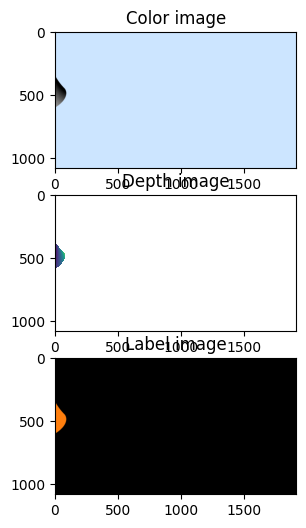

[    1 32766]


In [3]:
add_wsg = True 
add_board = False

builder = DiagramBuilder()
station = builder.AddSystem(
    MakeChessManipulationStation(meshcat=meshcat, add_board=add_board, add_wsg=add_wsg))
plant = station.GetSubsystemByName("plant")
scene_graph = station.GetSubsystemByName("scene_graph")
controller_plant = station.GetSubsystemByName(
    "panda_controller").get_multibody_plant_for_control()

viz = MeshcatVisualizer.AddToBuilder(
    builder,
    station.GetOutputPort("query_object"),
    meshcat)

meshcat.ResetRenderMode()
meshcat.DeleteAddedControls()

# Set up differential inverse kinematics.
differential_ik = AddPandaDifferentialIK( 
    builder,
    controller_plant,
    frame=controller_plant.GetFrameByName("panda_link8"))
builder.Connect(differential_ik.get_output_port(),
                station.GetInputPort("panda_position"))
builder.Connect(station.GetOutputPort("panda_state_estimated"),
                differential_ik.GetInputPort("robot_state"))

# Set up teleop widgets.
q0 = [0.0, 0, 0.0, -np.pi/2, 0.0, np.pi/2, np.pi/4]
teleop = builder.AddSystem(
    MeshcatPoseSliders(
        meshcat,
        min_range=MeshcatPoseSliders.MinRange(roll=0,
                                                pitch=-0.5,
                                                yaw=-np.pi,
                                                x=-0.4,
                                                y=-0.4,
                                                z=0.0),
        max_range=MeshcatPoseSliders.MaxRange(roll=2 * np.pi,
                                                pitch=np.pi,
                                                yaw=np.pi,
                                                x=0.4,
                                                y=0.25,
                                                z=0.75),
        body_index=plant.GetBodyByName("panda_link8").index(),
        # It seems that value is set by the default joint positions, not here.
        value=MeshcatPoseSliders.Value(roll=0.0,  # idk if this part works...  
                                    pitch=0.0,
                                    yaw=0.0,
                                    x=0.0,
                                    y=0.0,
                                    z=0.5)))
builder.Connect(teleop.get_output_port(0),
                differential_ik.get_input_port(0))
builder.Connect(station.GetOutputPort("body_poses"),
                teleop.GetInputPort("body_poses"))

if add_wsg:
    wsg_teleop = builder.AddSystem(WsgButtonPanda(meshcat))
    builder.Connect(wsg_teleop.get_output_port(0),
                    station.GetInputPort("Schunk_Gripper_position"))
    builder.Connect(station.GetOutputPort("Schunk_Gripper_state_measured"),
                    wsg_teleop.GetInputPort('wsg_state_measured'))
    # builder.Connect(station.GetOutputPort("Schunk_Gripper_force_measured"),
    #                 wsg_teleop.GetInputPort('wsg_force_measured'))

diagram = builder.Build()

# plant.SetPositions(context_plant, plant.GetModelInstanceByName("panda"), q0)

simulator = Simulator(diagram)
context = simulator.get_mutable_context()

simulator.set_target_realtime_rate(1.0)

meshcat.AddButton("Stop Simulation", "Escape")
print("Press Escape to stop the simulation")

station_context = station.CreateDefaultContext()

simulator.AdvanceTo(0.01)

color_image = station.GetOutputPort("camera1_rgb_image").Eval(station_context)
depth_image = station.GetOutputPort("camera1_depth_image").Eval(station_context)
label_image = station.GetOutputPort("camera1_label_image").Eval(station_context)


## Plot the two images.
f = plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.imshow(color_image.data)
plt.title('Color image')
plt.subplot(312)
plt.imshow(np.squeeze(depth_image.data))
plt.title('Depth image')
plt.subplot(313)
plt.imshow(np.squeeze(colorize_labels(label_image.data)))
plt.title('Label image')
#mpld3.display()
plt.show()

plt.imshow(color_image.data)
# plt.savefig('color_board.png')
print(np.unique(label_image.data))

im = Image.fromarray(color_image.data)
im.save("color_board.png")


mut_station_context = diagram.GetMutableSubsystemContext(station, context)
def print_status():
    link_8_index = plant.GetBodyByName("panda_link8").index()
    print('Estimated state: ', station.GetOutputPort('body_poses').Eval(mut_station_context)[link_8_index])

# -- Uncomment to simulate -- #
cnt = 0
while meshcat.GetButtonClicks("Stop Simulation") < 1:
    simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
    # if cnt % 10 == 0:
    #     print_status()
    #     input('Continue')
    # cnt += 1

meshcat.DeleteButton("Stop Simulation")


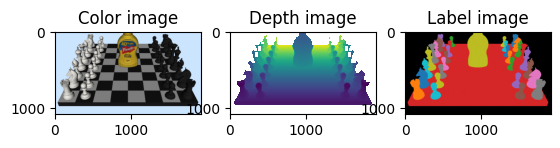

[   13    14    15    16    17    18    19    20    21    22    23    24
    25    26    27    28    29    30    31    32    33    34    35    36
    37    38    39    40    41    42    43    44    45    48 32766]


In [4]:
# Visualize other camera
color_image = station.GetOutputPort("camera2_rgb_image").Eval(station_context)
depth_image = station.GetOutputPort("camera2_depth_image").Eval(station_context)
label_image = station.GetOutputPort("camera2_label_image").Eval(station_context)

# Plot the two images.
plt.subplot(131)
plt.imshow(color_image.data)
plt.title('Color image')
plt.subplot(132)
plt.imshow(np.squeeze(depth_image.data))
plt.title('Depth image')
plt.subplot(133)
plt.imshow(np.squeeze(colorize_labels(label_image.data)))
plt.title('Label image')
#mpld3.display()
plt.show()
print(np.unique(label_image.data))

## Below is legacy code for reference
Don't try to run it because it doesn't work lol

In [ ]:
# OLD

scene_graph = station.GetSubsystemByName("scene_graph")

viz = MeshcatVisualizer.AddToBuilder(
    builder,
    station.GetOutputPort("query_object"),
    meshcat)

q0 = [0.0, 0, 0.0, -np.pi/2, 0.0, np.pi/2, np.pi/4, 0.04, 0.04]
t_lst = np.linspace(0, 5, 30)
# q_knots = np.repeat(np.array(q0).reshape(1, -1), 30, axis=0)
q_knots = []
working_q = np.array(q0)
dt = 0.01
for i in range(30):
    working_q[0] += dt
    q_knots.append(working_q.copy())

print(q_knots)
q_knots = np.vstack(q_knots)
print(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:9].T)

q_traj_system = builder.AddSystem(TrajectorySource(q_traj))

builder.Connect(q_traj_system.get_output_port(),
                station.GetInputPort("panda_position"))

diagram = builder.Build()

context_diagram = diagram.CreateDefaultContext()
context_station = diagram.GetSubsystemContext(station, context_diagram)
context_scene_graph = station.GetSubsystemContext(scene_graph, context_station)
context_plant = station.GetMutableSubsystemContext(plant, context_station)

plant.SetPositions(context_plant, plant.GetModelInstanceByName("panda"), q0)

diagram.Publish(context_diagram)

simulator = Simulator(diagram)
simulator.set_publish_at_initialization(True)
simulator.Initialize()
simulator.set_target_realtime_rate(1.0)

simulator.AdvanceTo(5)






In [ ]:
# THIS CELL NOT USED
builder = DiagramBuilder()
station = builder.AddSystem(
    MakeChessManipulationStation())
plant = station.GetSubsystemByName("plant")
scene_graph = station.GetSubsystemByName("scene_graph")

viz = MeshcatVisualizer.AddToBuilder(
    builder,
    station.GetOutputPort("query_object"),
    meshcat)

q0 = [0.0, 0, 0.0, -np.pi/2, 0.0, np.pi/2, np.pi/4, 0.04, 0.04]
t_lst = np.linspace(0, 5, 30)
# q_knots = np.repeat(np.array(q0).reshape(1, -1), 30, axis=0)
q_knots = []
working_q = np.array(q0)
dt = 0.01
for i in range(30):
    working_q[0] += dt
    q_knots.append(working_q.copy())

print(q_knots)
q_knots = np.vstack(q_knots)
print(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:9].T)

q_traj_system = builder.AddSystem(TrajectorySource(q_traj))

builder.Connect(q_traj_system.get_output_port(),
                station.GetInputPort("panda_position"))

diagram = builder.Build()

context_diagram = diagram.CreateDefaultContext()
context_station = diagram.GetSubsystemContext(station, context_diagram)
context_scene_graph = station.GetSubsystemContext(scene_graph, context_station)
context_plant = station.GetMutableSubsystemContext(plant, context_station)

plant.SetPositions(context_plant, plant.GetModelInstanceByName("panda"), q0)

diagram.Publish(context_diagram)

simulator = Simulator(diagram)
simulator.set_publish_at_initialization(True)
simulator.Initialize()
simulator.set_target_realtime_rate(1.0)

simulator.AdvanceTo(5)




